# Introduction

What problem are we trying to solve? Consider a scenario involving players who can compete against each other in pairs, resulting in one player winning and another losing. These players can be humans playing a game, such as chess. Alternatively, we might have a situation where people express their preferences by choosing one item (texts, videos, movies, pictures, songs) over another. In this case, the items themselves become the "players," with the chosen item "winning" and the other "losing".

Our goal is to be able to predict the outcomes of any two given "players" competing against each other. In other words, we want to be able to estimate the probability of any given player A to win against any other given player B, in case they are confronted to play agains each other. This question is relevant for pairs of players who have never played together as well as for those who have played together multiple times. For example, if players A and B have faced each other five times and player A won four out of those five games, we can estimate the probability of player A defeating player B as 0.8. However, we can make a much better estimate by examining player A's results against other players, as well as player B's results against other players. By considering a broader set of statistics, we can more accurately assess the strengths of both players and thus better predict the outcome when they play against each other.

# Data
To begin, we define and introduce an appropriate data structure for our analysis. We propose using a square matrix $W$, where $W_{ij}$ represents the number of wins player $i$ has over player $j$. In this matrix, the $i$-th row contains all the wins of player $i$, and the $j$-th column contains all the losses of player $j$. We will refer to this as the wins matrix.

# Model
We start with the following model. We assume that each player can be characterized by a single number, which we will refer to as strength, score, or index. Additionally, we assume that the probability of a given player winning against another one is entirely determined by their scores or, more specifically, by the difference between their scores. This implies that if the scores of two players are equal (the difference between their scores is zero) the two players are equally strong. Consequently, the probability of one player winning against another one is 0.5. As the difference between the scores increases, the probability of the first player winning over the second approaches 1.0. On the other hand, as the difference becomes negative, the probability of the first player winning drops below 0.5 (the first player loses more frequently). As the difference continues to decrease, the probability of winning approaches zero. One of the functions that has the described properties is sigmoid function. It can be defined either via exponents or hyperbolic tangent:

$$
\sigma(x) = \frac{1}{1 + e^{-x}} = \frac{e^{x}}{1 + e^{x}} = \frac{1}{2} \tanh(\frac{x}{2}) + \frac{1}{2}
$$

In [30]:
from scipy.special import expit
import matplotlib.pyplot as plt
import numpy as np
import random

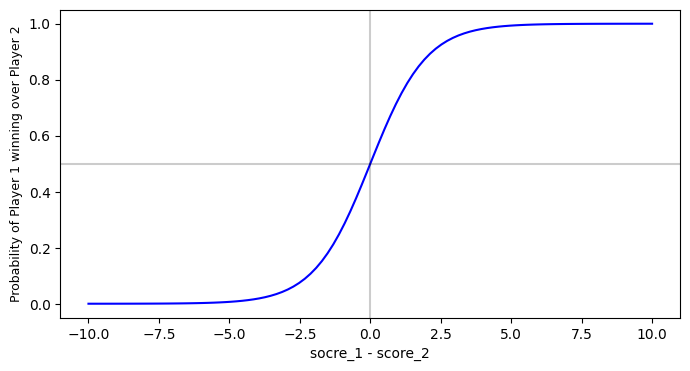

In [28]:
x = np.linspace(-10.0, 10.0, 100)
y = expit(x)

plt.figure(figsize = (8,4))
plt.xlabel('socre_1 - score_2')
plt.ylabel('Probability of Player 1 winning over Player 2', fontsize=9)
plt.plot(x, y, color = 'b')
plt.axhline(0.5, color = 'k', alpha = 0.2)
plt.axvline(0.0, color = 'k', alpha = 0.2)
plt.show()

# From Model to Data
In this section, we use the previously defined probabilistic model to generate data. To do this, we need to provide a list of $n$ scores corresponding to $n$ players. We will then return a wins matrix as described above. We will write a function that simulates a scenario where each player competes once with every other player, randomly generating wins and losses. The outcomes of these matches will be represented in an $n$ by $n$ wins matrix. Since each match produces one win, the sum of the elements in the wins matrix will equal the total number of games, which is $n \cdot (n - 1) / 2$.

In [6]:
def get_wins_matrix(scores):
    diffs = scores[:, np.newaxis] - scores[np.newaxis, :]
    probs = expit(diffs)
    x = np.random.rand(*probs.shape)
    wins = (x < probs).astype(int)
    wins_matrix = np.triu(wins, k=1) + np.triu(1 - wins, k=1).T
    np.fill_diagonal(wins_matrix, 0)
    return wins_matrix

In [7]:
n_players = 9
scores = np.linspace(-2.0, 2.0, n_players)
print('Scores:', scores)
wins_matrix = get_wins_matrix(scores)
print('\nWins Matrix:\n')
print(wins_matrix)

Scores: [-2.  -1.5 -1.  -0.5  0.   0.5  1.   1.5  2. ]

Wins Matrix:

[[0 0 0 0 0 1 1 0 0]
 [1 0 0 0 1 1 0 0 0]
 [1 1 0 1 1 0 0 0 0]
 [1 1 0 0 1 0 0 1 0]
 [1 0 0 0 0 0 1 0 0]
 [0 0 1 1 1 0 0 0 0]
 [0 1 1 1 0 1 0 1 0]
 [1 1 1 0 1 1 0 0 1]
 [1 1 1 1 1 1 1 0 0]]


The scores of the players range from -2.0 to 2.0 in steps of 0.5, indicating increasing player strength. Consequently, when we examine a row in the middle of the wins matrix, we will observe more 1s at the beginning of the row. This indicates that the player corresponding to the selected row has won against weaker players. In contrast, towards the end of the row, 1s become less frequent. Additionally, the first player, represented by the first row, almost never wins, while the last player, represented by the last row, almost always wins. To see the effect of strength on performance statistics, we simulate 100 rounds, meaning each player plays exactly 100 games against every other player.

In [8]:
n_rounds = 100
wins_matrix = np.zeros((n_players, n_players), dtype = int)
for _ in range(n_rounds):
    wins_matrix += get_wins_matrix(scores)
print(wins_matrix)

[[ 0 38 28 18 11  5  3  4  2]
 [62  0 41 22 13 19  7  6  3]
 [72 59  0 39 32 17  8  4 11]
 [82 78 61  0 30 20 26 10  9]
 [89 87 68 70  0 37 35 19 12]
 [95 81 83 80 63  0 38 27 18]
 [97 93 92 74 65 62  0 41 27]
 [96 94 96 90 81 73 59  0 36]
 [98 97 89 91 88 82 73 64  0]]


We can clearly see that even the weakest player (the first one) can win against stronger players, but this probability is below 0.5 and decreases further as we gradually move towards stronger opponents.

# From Data to Model

In this section, we connect our probabilistic model to our observed data. The core concept is that for a given model parameters (represented by a vector of players' scores), we aim to calculate the probability of observing our dataset (the wins matrix). Once we establish this relationship, we can initiate a search for the optimal scores that maximize the probability of our observed dataset. This approach is known as maximum likelihood estimation (MLE).

Calculating the probability of the observed wins matrix is quite straightforward. We loop over all elements of the win matrix, where each element contains the number of wins. For each win, we can calculate its probability using our probabilistic model. Since all games and their outcomes are independent events, we multiply all these probabilities to get the combined probability of the win matrix. This product gives us the likelihood of observing the given dataset under our model.
$$
p = \prod_{i,j} \sigma(s_i - s_j)^{w_{ij}}
$$
After taking the logarithm of the above expression, we get:
$$
\log(p) = \sum_{i,j} w_{ij} \cdot \log[\sigma(s_i - s_j)]
$$
Logarithm of sigmoid can be expressed as follows:
$$
\log[\sigma(x)] = -\log(1 + e^{-x})
$$
Therefore we can write our expression for negative log likelihood as follows. 
$$
L = -\log(p) = \sum_{i,j} w_{ij} \log[1 + \exp(s_j - s_i)]
$$

In [9]:
import numpy as np

def negative_log_likelihood(ratings, wins_matrix):
    diffs = ratings[:, np.newaxis] - ratings[np.newaxis, :]
    neg_log_probs = -np.log(expit(diffs))
    #neg_log_probs = np.logaddexp(0.0, -diffs)
    n_games = np.sum(wins_matrix)
    return np.nansum(wins_matrix * neg_log_probs) / n_games

In [10]:
from scipy.optimize import minimize

x0 = np.zeros(n_players)
result = minimize(negative_log_likelihood, x0, args=wins_matrix)

In [11]:
print('Estimated Scores:', np.round(result.x,3))

Estimated Scores: [-2.019 -1.486 -0.993 -0.511  0.113  0.533  0.956  1.473  1.932]


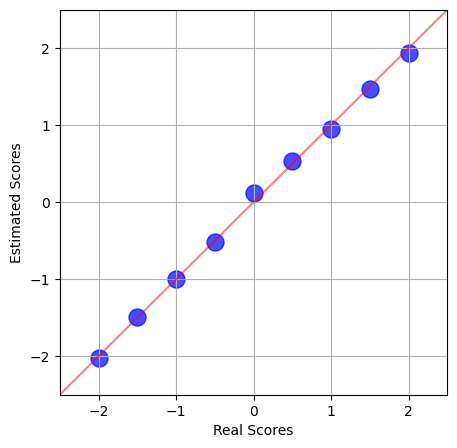

In [12]:
plt.figure(figsize = (5,5))
plt.xlabel('Real Scores')
plt.ylabel('Estimated Scores')
rng = [-2.5, 2.5]
plt.xlim(rng)
plt.ylim(rng)
plt.scatter(scores, result.x, color = 'b', s = 150, alpha = 0.7)
plt.plot(rng, rng, color = 'r', alpha = 0.5)
plt.grid()
plt.show()

# Gradient Based Optimization
A direct search of Elo ratings, performed in the previous section, can become highly inefficient as the number of players increases. This section introduces gradient-based optimization techniques to address this issue. We begin by deriving an analytical expression for gradients. Given an arbitrary list of Elo indices, we estimate how the negative log-likelihood changes as we vary each corresponding Elo index independently. This approach reveals the direction and magnitude of changes required for each Elo index to achieve the maximum improvement in negative log-likelihood.

We start from earlier derived expression for negative log likelihood:
$$
L = \sum_{i,j} w_{ij} \cdot \log[1 + \exp(s_j - s_i)]
$$
We proceed by taking derivative over one of the Elo scores ($s_k$):
$$
\frac{\partial L}{\partial s_k} = \sum_{i,j} w_{ij} \cdot \frac{\exp(s_j - s_i)}{1 + \exp(s_j - s_i)} \cdot (\delta_{jk} - \delta_{ik})
$$
The above expression can be simplified if we use the expression of the sigmoid function:  
$$
\frac{\partial L}{\partial s_k} = \sum_{i,j} w_{ij} \cdot \sigma(s_j - s_i) \cdot (\delta_{jk} - \delta_{ik})
$$
The above expression can be represented as a sum of two parts:
$$
\frac{\partial L}{\partial s_k} = \sum_{i} w_{ik} \cdot \sigma(s_k - s_i) - \sum_{j} w_{kj} \cdot \sigma(s_j - s_k)
$$
The last expression has a straightforward interpretation. For the $k$-th Elo rating, we first loop over the $k$-th column of the wins matrix, which contains all the losses of the $k$-th player. The Elo rating decreases each time we see a loss. This decrease in Elo rating (penalty) is larger with more losses observed and a greater difference between the $k$-th player's score and the opponent's score. In other words, we stronger reduce the Elo score of the player when we see a loss against a weaker opponent. Next, we loop over the $k$-th row, which contains the wins of the $k$-th player. Here, the logic is similar: we increase the Elo score of the player each time we see a win. The increase is larger with more wins and a greater difference between the opponent's score and the $k$-th player's score. A win against a stronger opponent will lead to a larger increase in the $k$-th Elo score.

In [42]:
def get_grads(ratings, wins_matrix):
    sigmoids = expit(ratings[:, np.newaxis] - ratings[np.newaxis, :])
    s1 = np.sum(wins_matrix * sigmoids.T, axis = 0)
    s2 = np.sum(wins_matrix * sigmoids.T, axis = 1)
    return (s1 - s2) / np.sum(wins_matrix)

In [46]:
ratings = np.random.normal(size = n_players)
delta = np.zeros(shape = n_players)
epsilon = pow(10.0, -6)
ind = random.randint(0, n_players - 1)
delta[ind] = epsilon
nll_0 = negative_log_likelihood(ratings, wins_matrix)
nll_1 = negative_log_likelihood(ratings + delta, wins_matrix)
deriv = (nll_1 - nll_0) / epsilon
grads = get_grads(ratings, wins_matrix)
print(deriv, grads[ind])

-0.05649130785378986 -0.0564913317410519


In [74]:
ratings = np.random.uniform(-3.0, 3.0, size = n_players)
all_ratings = [ratings]
lr = 0.1
for i in range(2000):
    grads = get_grads(ratings, wins_matrix)
    ratings = ratings - lr * grads
    all_ratings.append(ratings)
all_ratings = np.array(all_ratings)
print(all_ratings.shape)

(2001, 9)


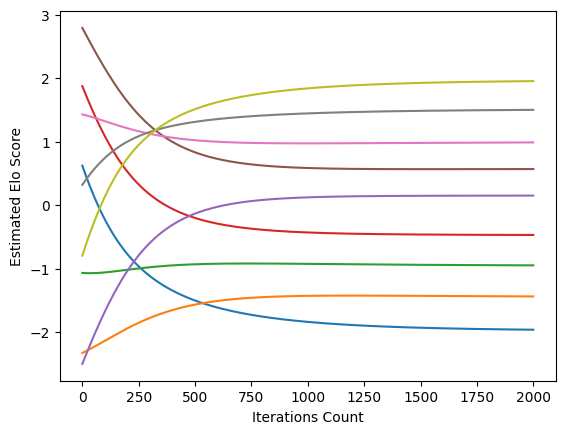

In [75]:
plt.figure()
plt.xlabel('Iterations Count')
plt.ylabel('Estimated Elo Score')
for i in range(n_players):
    plt.plot(all_ratings[:,i])
plt.show()

# Bradley-Terry Model
The Bradley-Terry model, similar to the Elo rating system, is a probabilistic model used to assign probabilities to the outcomes of pairwise comparisons between items (such as teams, players, objects). In this model, each player is represented by a single number, denoted as 
$p_i$. When players $i$ and $j$ compete against each other, the probability that player $i$ wins is given by:
$$
P_{ij} = \frac{p_i}{p_i + p_j}
$$
This model has a very simple intuitive representation. Let's say we have three players with scores of 100, 300, and 600, respectively. To model the probability of winning for any pair of players, we assign each player a number of balls equal to their score. For example, the first player receives 100 red balls, the second player receives 300 green balls, and the third player receives 600 blue balls.

When two players compete, they put all their balls into one bag. A judge then mixes the balls and pulls a random ball from the bag. The player whose ball is drawn from the bag wins the match.

In this setup, the second player had 3 times larger probability to win against the first player (300/100), and the third player has 6 times larger probability to win against the first player (500/100) and 2 times larger probability to win agains the second player (600/300).

The Bradley-Terry model has a very simple and straightforward relationship to the Elo scoring system. Recall that according to the Elo model, the probability of player $i$ winning against player $j$ is given by:
$$
P_{ij} = \sigma(s_i - s_j) = \frac{\exp(s_i - s_j)}{1 + \exp(s_i - s_j)} = \frac{\exp(s_i)}{\exp(s_j) + \exp(s_i)} = \frac{p_i}{p_i + p_j}
$$
To make the last step we have postulated that
$$
p_i = \exp(s_i)
$$
This we can say that the exponent of the Elo scores is nothing but Bradley-Terry scores.

Since the Bradley-Terry scores have a straightforward interpretation, as described above, we can transfer this interpretation to Elo scores. Namely, the probabilities of two players winning against each other are related as exponents of their Elo scores:
$$
\frac{P_{ij}}{P_{ji}} = \frac{\exp(s_i)}{\exp(s_j)}
$$
# Iterative Solution
Let's consider the problem we discussed earlier in the context of Elo scores. We have a wins matrix $w$ containing the counts of wins for each pair of players, where $w_{ij}$ represents the number of wins that player $i$ has against player $j$. We want to find the Bradley-Terry scores that best fit the given wins matrix. As before we start from the expression for log likelihood. It is a sum of log probabilities for all wins in the win matrix. 
$$
L = \sum_{ij} w_{ij} \cdot \log \left( \frac{p_i}{p_i + p_j} \right)
$$
To find the optimal values of the parameters $p_k$, we need to take the derivative with respect to these parameters and set the resulting expressions equal to zero.
$$
\frac{\partial L}{\partial p_k} = \sum_{ij} w_{ij} \cdot \frac{\partial}{\partial p_k} \log \left( \frac{p_i}{p_i + p_j} \right)
$$
$$
\frac{\partial L}{\partial p_k} = \sum_{ij} w_{ij} \cdot \frac{\partial}{\partial p_k} \left[ \log p_i - \log \left( p_i + p_j\right) \right]
$$
$$
\frac{\partial L}{\partial p_k} = \sum_{ij} w_{ij} \cdot \left( \frac{\delta_{ik}}{p_i} - \frac{\delta_{ik} + \delta_{jk}}{p_i + p_j} \right)
$$
$$
\frac{\partial L}{\partial p_k} = \sum_{j} \frac{w_{kj}}{p_k} - \sum_{j} \frac{w_{kj}}{p_k + p_j} - \sum_i \frac{w_{ik}}{p_i + p_k}
$$
Now we set the derivative to be equal to zero and perform some simple rearrangement.
$$
\frac{1}{p_k} \sum_{i} w_{ki} - \sum_{i} \frac{w_{ki} + w_{ik}}{p_i + p_k} = 0
$$
Ideally, we would like to solve the above expression with respect to $p_k$ . However, this equation does not permit an analytical solution. Nevertheless, we can rearrange it so that $p_k$​ is expressed in terms of other $p_k$.
$$
p_k = \frac{\sum_{i} w_{ki}}{\sum_{i} \left( w_{ki} + w_{ik} \right) / \left( p_i + p_k \right)}
$$

# Iterations

In [115]:
def get_new_ps_slow(w, p):
    p_i = p[:,np.newaxis]
    p_j = p[np.newaxis,:]
    nom = np.sum(w, axis = 1)
    den = np.sum((w + w.T)/(p_i + p_j), axis = 1)
    return nom/den

In [116]:
def get_new_ps_fast(w, p):
    p_i = p[:,np.newaxis]
    p_j = p[np.newaxis,:]
    nom = np.sum(w * p_j / (p_i + p_j), axis = 1)
    den = np.sum(w.T/(p_i + p_j), axis = 1)
    return nom/den

In [132]:
p_ini = np.random.uniform(0.0, 1.0, size = n_players)

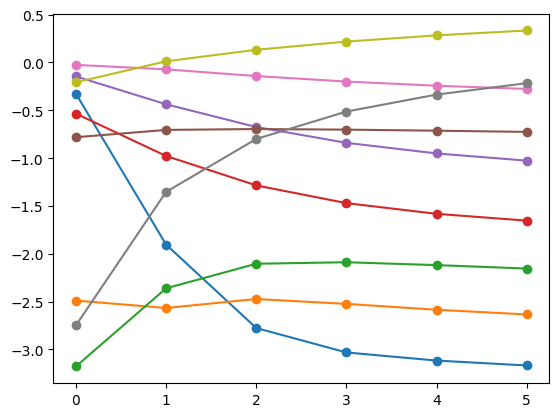

In [133]:
ps = [p_ini.copy()]
for i in range(5):
    p = get_new_ps_slow(wins_matrix, ps[-1])
    ps.append(p)
ps = np.array(ps)

plt.figure()
for i in range(n_players):
    plt.plot(np.log(ps[:,i]), marker = 'o')
plt.show()

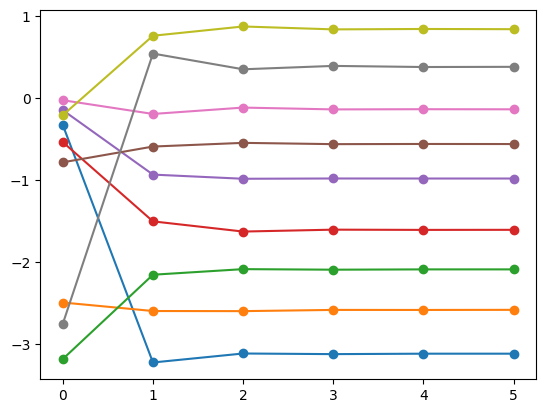

In [134]:
ps = [p_ini.copy()]
for i in range(5):
    p = get_new_ps_fast(wins_matrix, ps[-1])
    ps.append(p)
ps = np.array(ps)

plt.figure()
for i in range(n_players):
    plt.plot(np.log(ps[:,i]), marker = 'o')
plt.show()

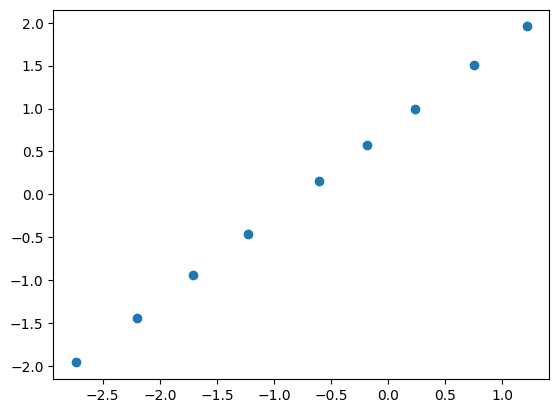

In [114]:
#plt.scatter(np.log(ps[-1]), scores)
plt.scatter(np.log(ps[-1]), all_ratings[-1])

In [2]:
with open('zhopa.txt','w') as f:
    f.write('wtf?')